In [0]:
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,MaxAbsScaler,Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

This data was generated by a scrape of vgchartz.com, a website that hosts a bunch of video game and console data such as their sales. The original script is available at https://github.com/GregorUT/vgchartzScrape. It had to be updated and altered to fit this project so it was not easy to collect. Due to rate limitation, it took almost 6 hours to run. The code is in the cells below. It does not reflect all code because unfortunately although Google Colab successfully saved some csv's to my drive, this notebook did not save (I think it had been running so long it didn't save the state of the notebook but I know it completed successfully). The code missing is just the code to save to Google Drive and to drop some columns.

This data represents data on games sold for the Xbox One. Vgchartz does not outline how they retrieve their data but it seems to be accurate and thus will provide suitable data for predicting a game's success. Some columns were dropped as I didn't need them (like specific country sales).

The fields include:

- Rank - Ranking of overall sales
- Name - The games name
- Year - Year of the game's release
- Genre - Genre of the game
- Publisher - Publisher of the game
- Developer
- Critic Score
- User Score
- Global_Sales - Total worldwide sales.

There are 1318 rows, each representing a game for the xbox one. Of those, 539 have reached over 10,000 sales (the minimum amount to have sales recorded on this website). Had to discard those.

The Xbox One was released in 2013 and has since sold ~46.6m units.

In [3]:
df_vg = pd.read_csv("https://raw.githubusercontent.com/thedanieljk/Data301FinalProject/master/df_vg_final.csv")
df_vg = df_vg.iloc[:539] #only 539 have recorded sales (over 10,000)
df_vg

,Rank,Name,Year,Genre,Publisher,Developer,Critic_Score,User_Score,Global_Sales
0,1,Grand Theft Auto V,2014.0,Action,Rockstar Games,Rockstar North,9.0,9.0,8.72
1,2,Call of Duty: Black Ops 3,2015.0,Shooter,Activision,Treyarch,NaN,NaN,7.37
2,3,Call of Duty: WWII,2017.0,Shooter,Activision,Sledgehammer Games,NaN,NaN,6.23
3,4,Red Dead Redemption 2,2018.0,Action-Adventure,Rockstar Games,Rockstar Games,NaN,NaN,5.77
4,5,Minecraft,2014.0,Misc,Microsoft Studios,Mojang,NaN,NaN,5.43
...,...,...,...,...,...,...,...,...,...
534,535,V-Rally 4,2018.0,Racing,Bigben Interactive,Kylotonn,NaN,NaN,0.01
535,536,Jagged Alliance: Rage!,2018.0,Strategy,THQ Nordic,Cliffhanger Productions,NaN,NaN,0.01
536,537,Ziggurat,2015.0,Shooter,Milkstone Studios,Milkstone Studios,NaN,NaN,0.01
537,538,ATV Renegades,2017.0,Racing,Nighthawk Interactive,Nighthawk Interactive,NaN,NaN,0.01


Sales were very clumped at under 100,000 sales with a mean of 53,000 and a median of 13,0000.

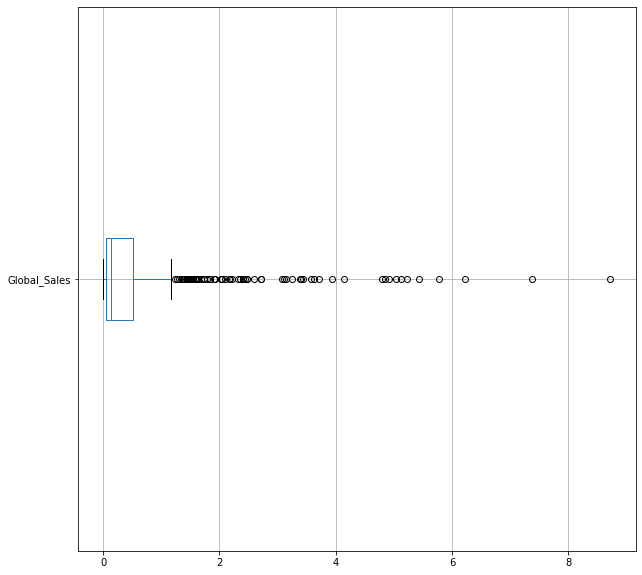

In [4]:
df_vg[["Global_Sales"]].boxplot(vert=False,figsize=(10,10))

<Figure size 1440x1440 with 0 Axes>

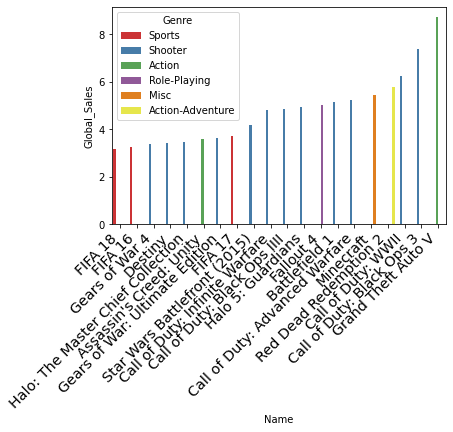

<Figure size 1440x1440 with 0 Axes>

In [8]:
df_top20 = df_vg.iloc[:20].iloc[::-1]
#get top20, reverse so ascending order
top20Chart = sns.barplot(x='Name', 
                         y='Global_Sales', 
                         hue='Genre', 
                         data=df_top20,
                         palette="Set1"
                         )
top20Chart.set_xticklabels(top20Chart.get_xticklabels(), 
                           rotation=45,
                           horizontalalignment="right",                        
                           fontweight='light',
                           fontsize='x-large')

plt.figure(figsize=(20,20))

Shooters represent 12 of the top 20 games, despite only having 67 games total.

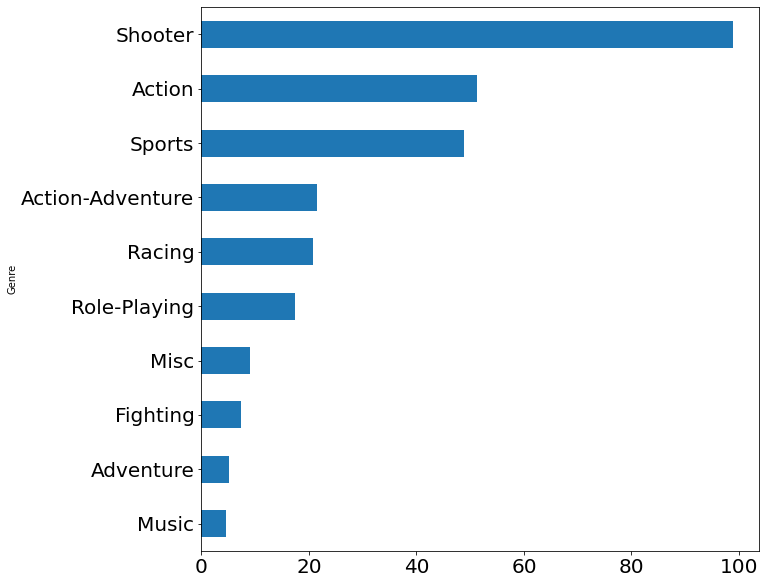

In [9]:
ax = (df_vg.groupby("Genre")["Global_Sales"].
 sum(axis=1).
 sort_values(ascending=False).
 iloc[:10].
 iloc[::-1].
 plot.barh(figsize=(10,10),fontsize="20"))


This trend holds true when you look at overall sales by genre.

In [11]:
def get_cv_err_categorical(features):
  ct = make_column_transformer(
      (OneHotEncoder(handle_unknown="ignore"), features),
      remainder="passthrough"
  )

  pipeline = make_pipeline(
      ct,
      KNeighborsRegressor(n_neighbors=3)
  )
  cv_errs = -cross_val_score(pipeline,
                             X=df_vg[features],
                             y=df_vg["Global_Sales"],
                             scoring="neg_mean_squared_error",cv=2)
  return cv_errs.mean()



errs = pd.Series()
for features in [["Genre"],["Publisher"],["Developer"]]:
  errs[str(features)] = get_cv_err_categorical(features)
errs

['Genre']         6.772372
['Publisher']    15.706889
['Developer']    22.778455
dtype: float64

The Genre was the most important single predictor of overall sales.

In [10]:
def get_cv_err(features):
  ct = make_column_transformer(
      (OneHotEncoder(handle_unknown="ignore"), features),
      remainder="passthrough"
  )

  pipeline = make_pipeline(
      ct,
      KNeighborsRegressor(n_neighbors=3)
  )
  cv_errs = -cross_val_score(pipeline,
                             X=df_vg[features],
                             y=df_vg["Global_Sales"],
                             scoring="neg_mean_squared_error",cv=4)
  return cv_errs.mean()



errs = pd.Series()
for features in [["Genre","Publisher"],["Genre","Developer"],["Publisher","Developer"],["Genre","Publisher","Developer"]]:
  errs[str(features)] = get_cv_err(features)
errs

['Genre', 'Publisher']                  6.595095
['Genre', 'Developer']                  6.791547
['Publisher', 'Developer']             10.153461
['Genre', 'Publisher', 'Developer']     5.464975
dtype: float64

When training a model, including Genre, Publisher, and Developer provided the best results.

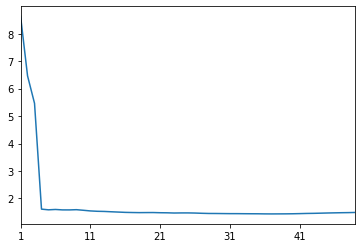

In [12]:
def get_cv_err_k(k):
  ct = make_column_transformer(
      (OneHotEncoder(handle_unknown="ignore"), ["Genre","Publisher","Developer"]),
      remainder="passthrough"
  )

  pipeline = make_pipeline(
      ct,
      KNeighborsRegressor(n_neighbors=k)
  )
  cv_errs = -cross_val_score(pipeline,
                             X=df_vg[["Genre","Publisher","Developer"]],
                             y=df_vg["Global_Sales"],
                             scoring="neg_mean_squared_error",cv=4)
  return cv_errs.mean()



errs = pd.Series()
for k in range(1,50):
  errs[str(k)] = get_cv_err_k(k)
errs.plot(kind="line")

Using a higher k-value tended to have higher results

In [13]:
def get_cv_err_linear(features):
  ct = make_column_transformer(
      (OneHotEncoder(handle_unknown="ignore"), features),
      remainder="passthrough"
  )

  pipeline = make_pipeline(
      ct,
      StackingRegressor([
    ("linear", LinearRegression()), 
    ("knn", KNeighborsRegressor(n_neighbors=30))],
    final_estimator=LinearRegression()
)
  )
  cv_errs = -cross_val_score(pipeline,
                             X=df_vg[features],
                             y=df_vg["Global_Sales"],
                             scoring="neg_mean_squared_error",cv=2)
  return cv_errs.mean()



errs = pd.Series()
for features in [["Genre","Publisher"],["Genre","Developer"],["Publisher","Developer"],["Genre","Publisher","Developer"]]:
  errs[str(features)] = get_cv_err_linear(features)
errs

['Genre', 'Publisher']                 2.108843
['Genre', 'Developer']                 1.977563
['Publisher', 'Developer']             2.217341
['Genre', 'Publisher', 'Developer']    2.177001
dtype: float64

Linear Regression didn't provide as good of a model (best was around ~2) vs k-nearest neighbors (~1.5 mse with a good k-value).

Unfortunately I was unable to come up with a good model. This is a case where the model is only going to be as good as the the data used. I was unable to collect enough data due to rate limitations (limited me to one platform). This project would have been better if it was combined with reviews from more reputable sources such as IGN.